In [ ]:
#| default_exp training.cnn

# Training & validation (CNN)

> Various utilities function to train and evaluate the Convolutional Neural Network model

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

In [ ]:
#|export
# Python utils
from collections import OrderedDict
import pickle
from tqdm.auto import tqdm
from functools import partial, reduce
import operator
from pathlib import Path
import math
import glob
import re


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from mirzai.data.loading import load_kssl
from mirzai.data.selection import (select_y, select_tax_order, select_X)
from mirzai.data.transform import log_transform_y
from mirzai.data.torch import DataLoaders, SNV_transform
from mirzai.training.metrics import eval_reg
from mirzai.training.core import is_plateau

# Deep Learning stack
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import CyclicLR
from torch.nn import MSELoss

from fastcore.test import *
from fastcore.basics import store_attr
from fastcore.transform import compose

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#|export
# https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch
class Model(nn.Module):
    def __init__(self, input_dim, in_channel=1, out_channel=16, is_classifier=False,
                 dropout=0.4):
        super(Model, self).__init__()
        # Build the neural network
        self.feature_extractor = nn.Sequential(
            self.make_convpool_block(in_channel, out_channel),
            self.make_convpool_block(out_channel, out_channel*2),
            self.make_convpool_block(out_channel*2, out_channel*4),
            self.make_convpool_block(out_channel*4, out_channel*8),
            self.make_convpool_block(out_channel*8, out_channel*16))

        num_features_before_fcnn = reduce(operator.mul,
                                          self.feature_extractor(torch.rand(1, in_channel, input_dim)).shape)

        output_layers = [nn.Dropout(dropout),
                         nn.Linear(in_features=num_features_before_fcnn, out_features=20),
                         nn.BatchNorm1d(20),
                         nn.LeakyReLU(0.1),
                         nn.Linear(in_features=20, out_features=1)];

        if is_classifier:
            output_layers.append(nn.Sigmoid())

        self.output_block = nn.Sequential(*output_layers)

    def make_convpool_block(self, input_channels, output_channels, kernel_size=3, stride=1):
        return nn.Sequential(
            nn.Conv1d(input_channels, output_channels, kernel_size, bias=False),
            nn.BatchNorm1d(output_channels),
            nn.LeakyReLU(0.1),
            nn.AvgPool1d(3))

    def forward(self, x):
        batch_size = x.size(0)
        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.output_block(out)
        return out

In [ ]:
#|export
def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
    if isinstance(m, nn.BatchNorm1d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
#|export
class Learner():
    def __init__(self, 
                 model, 
                 criterion=nn.MSELoss(), 
                 opt=torch.optim.Adam, 
                 n_epochs=50,
                 scheduler=None, 
                 early_stopper= None, 
                 tax_lookup=range(13), 
                 verbose=True
                ):
        store_attr() # see https://fastpages.fast.ai/fastcore
        use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if use_cuda else 'cpu')
        self._init_losses()

    def fit(self, 
            training_generator, 
            validation_generator,
            losses_append=None
           ):
        if losses_append is None: self._init_losses()
            
        for epoch in range(self.n_epochs):
            print(30*'-')
            print(f'Epoch: {epoch}')
            loss_train = []
            loss_valid = []
            
            loss_valid_tax = [[] for i in range(len(self.tax_lookup))]
            
            # Training loop
            self.model.train()
            for batches in training_generator:
                local_batch, local_labels, _ = self._to_device(batches)
                if len(local_batch) > 1:
                    self.opt.zero_grad() 
                    y_hat, loss = self.eval(local_batch, local_labels)
                    loss.backward(retain_graph=True) 
                    self.opt.step()
                    loss_train.append(loss.item())


            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for batches in validation_generator:
                    local_batch, local_labels, local_tax = self._to_device(batches)
                    if len(local_batch) > 1:
                        y_hat, loss = self.eval(local_batch, local_labels)
                        loss_valid.append(loss.item())
                    
                        # Eval by tax order
                        for tax in self.tax_lookup:
                            mask = (local_tax == tax).squeeze()
                            if torch.sum(mask).item() == 0:
                                loss_valid_tax[tax].append(float('nan'))
                            else:
                                _, loss = self.eval(local_batch[mask, :, :], local_labels[mask, :])
                                loss_valid_tax[tax].append(loss.item())
                            
            # mean losses after an epoch
            mean_loss_train = np.mean(np.array(loss_train))
            mean_loss_valid = np.mean(np.array(loss_valid))
            mean_loss_valid_tax = np.nanmean(np.array(loss_valid_tax), axis=1)
            
            if self.scheduler is not None:
                self.scheduler.step()

            if self.verbose:
                print(f'Training loss: {mean_loss_train} | Validation loss: {mean_loss_valid}')

            self.losses['train'].append(mean_loss_train)
            self.losses['valid'].append(mean_loss_valid)
            self.losses['valid_tax'].append(mean_loss_valid_tax)

            # At the end of a Cyclic learning rate cycle check if levelling
            losses_end_cycle = np.array(
                [el 
                 for i, el in enumerate(self.losses['valid']) 
                 if not i % self.scheduler.total_size])
            print(f'Validation loss (ends of cycles): {losses_end_cycle}')
            if self.early_stopper(losses_end_cycle):
                print('Early stopping!')
                
                break
            
        return self.model, self.losses

    def lr_finder(self,
                  training_generator,
                  start=1e-6,
                  end=1e-1,
                  n_epochs=8
                 ):
        opt = torch.optim.Adam(self.model.parameters(), lr=start)
        lr_lambda = lambda x: math.exp(x * math.log(end / start) / (n_epochs * len(training_generator)))
        scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
        criterion = nn.MSELoss()
        
        lrs = []
        losses = []
        i = 0
        smoothing = 0.01
        for epoch in range(n_epochs):
            print(f'Epoch: {epoch}')
            self.model.train()
            for batches in training_generator:
                local_batch, local_labels, local_tax = self._to_device(batches)
                if len(local_batch) > 1:
                    opt.zero_grad()
                    y_hat = self.model(local_batch)
                    loss = criterion(y_hat, local_labels)
                    loss.backward()
                    opt.step()

                    # update lr
                    scheduler.step()
                    lr_step = opt.state_dict()["param_groups"][0]["lr"]
                    lrs.append(lr_step)

                    # smooth loss
                    if i == 0:
                        losses.append(loss.item())
                    else:
                        loss = smoothing  * loss + (1 - smoothing) * losses[-1]
                        losses.append(loss.item())
                    i += 1
        return lrs, losses
        
    def eval(self, 
             X, 
             y
            ):
        y_hat = self.model(X)
        loss = self.criterion(y_hat, y)
        return y_hat, loss

    def predict(self, 
                data_generator,
                sample=None
               ):
        self.model.eval() if sample is None else self._MCDropoutOn()
        ys_hat, ys = [], []
        if sample is not None: raise Exception(f'MCDropout needs refactoring')
        with torch.no_grad():
            for batches in data_generator:
                local_batch, local_labels, _ = self._to_device(batches)
                if sample is None:
                    ys_hat.append(self.model(local_batch))
                else:
                    # TO BE FIXED: MCDROPOUT
                    y_hat = np.stack([self.model(local_batch).cpu() for s in tqdm(range(sample))]).squeeze()
                ys.append(local_labels)
        return [self._npify(torch.cat(y)) for y in (ys_hat, ys)]

    def _to_device(self, 
                   batches
                  ):
        if self.device.type == 'cpu': return batches
        return (batch.to(self.device) for batch in batches)

    def _init_losses(self):
        self.losses = {'train': [], 'valid': [], 'valid_tax': []}

    def _MCDropoutOn(self):
         # Check https://discuss.pytorch.org/t/turn-off-batch-norm-but-leave-dropout-on/14815
        # to deactivate BatchNorm during inference (maybe not critical when predicting all set)
        # and
        # for m in model.modules():
        #   if isinstance(m, nn.BatchNorm1d):
        #     m.eval()
        self.model.train()
        for m in self.model.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.eval()
    def _npify(self, 
               tensor
              ):
        if self.device.type == 'cpu': return tensor.numpy()
        return tensor.cpu().numpy()

In [ ]:
#|export
class Learners():
    def __init__(self, 
                 model,
                 tax_lookup,
                 seeds=range(20), 
                 device='cpu',
                 verbose=True, 
                 split_ratio=0.1):
        store_attr() # see https://fastpages.fast.ai/fastcore
         
    def train(self,
              data,
              order=None,
              dest_dir_loss='',
              dest_dir_model='',
              optimizer=torch.optim.Adam,
              scheduler=torch.optim.lr_scheduler.CyclicLR,
              criterion=nn.MSELoss(),
              n_epochs=201,
              early_stop=1e-4,
              sc_kwargs={}):
        
        X, y, tax_order = data                
        for seed in self.seeds:
            print(80*'-')
            print(f'Seed: {seed}')
            print(80*'-')

            generators = self._get_generators((X, y, tax_order), seed, order=order)
            training_generator, validation_generator, test_generator  = generators

            # Modeling
            model = self.model(X.shape[1], out_channel=16).to(device)
            opt = optimizer(model.parameters())
            model = model.apply(weights_init)
            early_stopper = partial(is_plateau, delta=early_stop, verbose=False)
            learner = Learner(model, criterion, opt, n_epochs=n_epochs,
                              scheduler=scheduler(opt, **sc_kwargs), 
                              early_stopper=early_stopper,
                              tax_lookup=self.tax_lookup.values(),
                              verbose=self.verbose)
            
            model, losses = learner.fit(training_generator, validation_generator)

            with open(dest_dir_loss/f'cnn-loss-seed-{seed}.pickle', 'wb') as f: 
                pickle.dump(losses, f)

            torch.save(model.state_dict(), dest_dir_model/f'model-seed-{seed}.pt')
    
    def evaluate(self,
                 data,
                 order=None,
                 batch_size=32,
                 src_dir_model=''):
        X, y, tax_order = data
        perfs = []
        y_hats = []
        y_trues = []
        ns = []
        for fname in glob.glob(str(src_dir_model/'*.pt')):
            model = Model(X.shape[1], out_channel=16).to(device)
            model.load_state_dict(torch.load(fname))
            learner = Learner(model, tax_lookup=self.tax_lookup.values())
            seed = int(re.search(r'-(\d+)\.', fname).group(1))
            generators = self._get_generators((X, y, tax_order), seed, order=order)
            training_generator, validation_generator, test_generator  = generators
            nb_data_gen = np.sum(1 for _ in test_generator)
            if nb_data_gen > 1:
                y_hat, y_true = learner.predict(test_generator)
                perfs.append(eval_reg(y_true, y_hat))
                y_hats.append(y_hat.ravel())
                y_trues.append(y_true.ravel())
                ns.append(nb_data_gen*batch_size)
        return pd.DataFrame(perfs), pd.DataFrame(y_hats).T, pd.DataFrame(y_trues).T, pd.DataFrame(ns)
            
    
    def _get_generators(self, data, seed, batch_size=32, order=None):
        X, y, tax_order = data
        # Train/test split
        data = train_test_split(X, 
                                y, 
                                tax_order, 
                                test_size=self.split_ratio,
                                random_state=seed)
        X_train, X_test, y_train, y_test, tax_order_train, tax_order_test = data
        data_test = X_test, y_test, tax_order_test

        # Further train/valid split
        data = train_test_split(X_train, 
                                y_train,
                                tax_order_train,
                                test_size=self.split_ratio, 
                                random_state=seed)
        X_train, X_valid, y_train, y_valid, tax_order_train, tax_order_valid = data
        data_train = X_train, y_train, tax_order_train
        data_valid = X_valid, y_valid, tax_order_valid

        if order is not None:
            data_train, data_valid, data_test = [self._filter(data, order=order) 
                                                 for data in [data_train, data_valid, data_test]]
           
        dls = DataLoaders(data_train, 
                          data_valid,
                          data_test,
                          transform=SNV_transform(),
                          batch_size=batch_size)

        training_generator, validation_generator, test_generator = dls.loaders()
        for batches in validation_generator:
            local_batch, local_labels, local_tax = batches
        return training_generator, validation_generator, test_generator
    
    def _filter(self, data, order=None):
        X, y, tax_order = data
        mask = tax_order == order
        return X[mask, :], y[mask], tax_order[mask]

## How to use the Model, Learner and Learners?

### 1. Load data

In [ ]:
src_dir = 'test'
fnames = ['spectra-features-smp.npy', 'spectra-wavenumbers-smp.npy', 
          'depth-order-smp.npy', 'target-smp.npy', 
          'tax-order-lu-smp.pkl', 'spectra-id-smp.npy']

# Or real data
#src_dir = '../_data'
#fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
#          'depth-order.npy', 'target.npy', 
#          'tax-order-lu.pkl', 'spectra-id.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)
transforms = [select_y, select_tax_order, select_X, log_transform_y]

data = X, y, X_id, depth_order
X, y, X_id, depth_order = compose(*transforms)(data)
print(X.shape)

(79, 1764)


### 2. Configure

In [ ]:
# Is a GPU available?
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'Runtime is: {device}')

params_scheduler = {
    'base_lr': 3e-5,
    'max_lr': 1e-3,
    'step_size_up': 5,
    'mode': 'triangular',
    'cycle_momentum': False
}

n_epochs = 21
seeds = range(2)

Runtime is: cpu


### 3. Train

In [ ]:
# Replace following Paths with yours
dest_dir_loss = Path('test/dumps-test/cnn/train_eval/all/losses')
dest_dir_model = Path('test/dumps-test/cnn/train_eval/all/models')


learners = Learners(Model, tax_lookup, seeds=seeds, split_ratio=0.1, device=device)
learners.train((X, y, depth_order[:, -1]), 
               dest_dir_loss=dest_dir_loss,
               dest_dir_model=dest_dir_model,
               n_epochs=n_epochs,
               sc_kwargs=params_scheduler)

--------------------------------------------------------------------------------
Seed: 0
--------------------------------------------------------------------------------
------------------------------
Epoch: 0
Training loss: 0.2095176726579666 | Validation loss: 0.28754910826683044
Validation loss (ends of cycles): [0.28754911]
------------------------------
Epoch: 1
Training loss: 0.20893988013267517 | Validation loss: 0.2862740755081177
Validation loss (ends of cycles): [0.28754911]
------------------------------
Epoch: 2
Training loss: 0.20712845027446747 | Validation loss: 0.28408676385879517
Validation loss (ends of cycles): [0.28754911]
------------------------------
Epoch: 3
Training loss: 0.20162831246852875 | Validation loss: 0.2809036374092102
Validation loss (ends of cycles): [0.28754911]
------------------------------
Epoch: 4
Training loss: 0.1960785835981369 | Validation loss: 0.2767537534236908
Validation loss (ends of cycles): [0.28754911]
------------------------------

### 4. Evaluate

In [ ]:
# Replace following Paths with yours
src_dir_model = Path('test/dumps-test/cnn/train_eval/all/models')
learners = Learners(Model, tax_lookup, seeds=seeds, device=device)
perfs_global_all, y_hats_all, y_trues_all, ns_all = learners.evaluate((X, y, depth_order[:, -1]),
                                                                      src_dir_model=src_dir_model)

In [ ]:
learners.evaluate((X, y, depth_order[:, -1]), src_dir_model=src_dir_model)

(Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [])

### 5. Learning rate finder

In [ ]:
split_ratio = 0.1

# Train/test split
X_train, X_test, y_train, y_test, tax_order_train, tax_order_test = train_test_split(X, 
                                                                                     y, 
                                                                                     depth_order[:,1], 
                                                                                     test_size=split_ratio,
                                                                                     random_state=42)

# Further train/valid split
X_train, X_valid, y_train, y_valid, tax_order_train, tax_order_valid = train_test_split(X_train, 
                                                                                      y_train,
                                                                                      tax_order_train, 
                                                                                      test_size=split_ratio, 
                                                                                      random_state=42)


dls = DataLoaders((X_train, y_train, tax_order_train), 
                  (X_valid, y_valid, tax_order_valid),
                  (X_test, y_test, tax_order_test), 
                  transform=SNV_transform())

training_generator, validation_generator, test_generator = dls.loaders()

In [ ]:
n_epochs = 2
step_size_up = 5
criterion = MSELoss() # Mean Squared Error loss
base_lr, max_lr = 3e-5, 1e-3 # Based on learning rate finder

In [ ]:
## LR finder
model = Model(X.shape[1], out_channel=16).to(device)

opt = Adam(model.parameters(), lr=1e-4)
model = model.apply(weights_init)

scheduler = CyclicLR(opt, base_lr=base_lr, max_lr=max_lr,
                     step_size_up=step_size_up, mode='triangular',
                     cycle_momentum=False)

learner = Learner(model, criterion, opt, n_epochs=n_epochs, 
                  scheduler=scheduler, early_stopper=None,
                  tax_lookup=tax_lookup.values(), verbose=True)

lrs, losses = learner.lr_finder(training_generator, end=0.1, n_epochs=8)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7


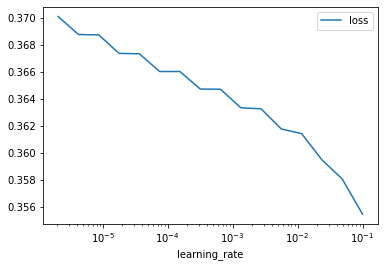

In [ ]:
pd.DataFrame({'learning_rate': lrs, 'loss': losses}).plot(x='learning_rate', y='loss', logx=True);